In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
url = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data'
df = pd.read_csv(url, sep='\t', header=0)
df = df.drop('Unnamed: 0', axis=1)   # skip the column of indices

In [8]:
df.head(6)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
5,-1.049822,3.228826,50,-1.386294,0,-1.386294,6,0,0.765468,T


In [20]:
names = df.columns.tolist()
names_x = names[0:7]
names_y = names[8]
print("Target Vairbale: %s"%names_y)
print("Predictors: "+str(names_x))

x0 = np.array(df[names_x])
y0 = np.array(df[names_y])
nsamp = x0.shape[0]
nfeatures = x0.shape[1]
x0.shape

Target Vairbale: lpsa
Predictors: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason']


(97, 7)

In [26]:
import sklearn.preprocessing

x = sklearn.preprocessing.scale(x0)
y = sklearn.preprocessing.scale(y0)

In [28]:
from sklearn import linear_model
from sklearn.model_selection import train_test_splitimport  sklearn.model_selection


In [32]:
xtr,xts,ytr,yts = train_test_split(x,y,test_size = 0.5, shuffle = True)
ntr = xtr.shape[0]
nts = xts.shape[0]
print("num samples train = %d test=%d"%(ntr,nts))


num samples train = 48 test=49


In [35]:
regr = linear_model.LinearRegression()
regr.fit(xtr,ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [37]:
ytrpred = regr.predict(xtr)
rqtr = 1- np.mean((ytrpred-ytr)**2)/np.std(ytr)**2
print("R^2 training = %f" %rqtr)

R^2 training = 0.618804


In [41]:
ytspred = regr.predict(xts)
rqts = 1-np.mean((ytspred - yts)**2)/np.std(yts)**2
print("Normalized test R^2: %f" %rqts )

Normalized test R^2: 0.663842


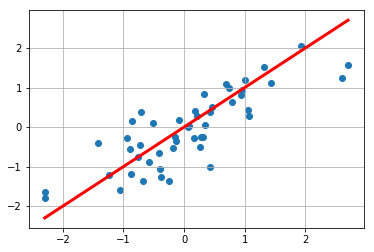

In [49]:
plt.scatter(yts,ytspred)
ymin = np.min(ytspred)
ymin = np.min(yts)
ymax = np.max(yts)
plt.plot([ymin,ymax],[ymin,ymax], "r-",linewidth= 3)
plt.grid()
plt.show()


    lcavol    0.6416
   lweight    0.2162
       age   -0.1395
      lbph    0.1106
       svi    0.1704
       lcp    0.0049
   gleason    0.0580


<StemContainer object of 3 artists>

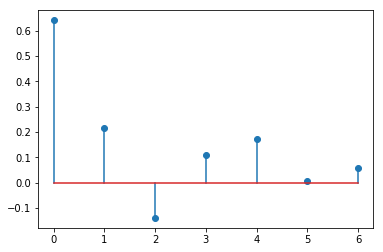

In [53]:
w = regr.coef_
for name,wi in zip(names_x,w):
    print("%10s %9.4f" %(name,wi))
plt.stem(w)

In [55]:
import  sklearn.model_selection

In [74]:
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle = True )

nalpha = 100
alphas = np.logspace(-3,1,nalpha)

mse = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(x)):
    itr,its = ind
    xtr = x[itr,:]
    ytr = y[itr]
    xts = x[its,:]
    yts = y[its]
    
    for ia,a in enumerate(alphas):
        model = linear_model.Lasso(alpha=a)
        model.fit(xtr,ytr)
        
        ytspred = model.predict(xts)
        mse[ia,ifold] = np.mean((ytspred-yts)**2)

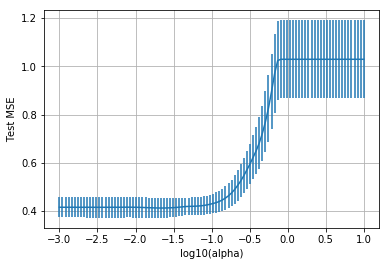

In [76]:
mse_mean = np.mean(mse,axis=1)
mse_se = np.std(mse,axis=1) / np.sqrt(nfold-1)
plt.errorbar(np.log10(alphas), mse_mean, yerr=mse_se)
plt.xlabel('log10(alpha)')
plt.ylabel('Test MSE')
plt.grid()
plt.show()


Optimal alpha 0.138489


(0.35, 1.6)

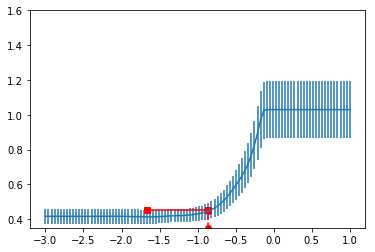

In [89]:
imin = np.argmin(mse_mean)
mse_tgt = mse_mean[imin]+mse_se[imin]
alpha_min = alphas[imin]

I = np.where(mse_mean < mse_tgt)[0]
iopt = I[-1]
alpha_opt = alphas[iopt]
print("Optimal alpha %f"%(alpha_opt))

plt.errorbar(np.log10(alphas),mse_mean,yerr = mse_se)

aminlog = np.log10(alpha_min)
aoptlog = np.log10(alpha_opt)

plt.plot([aminlog,aoptlog],[mse_tgt,mse_tgt],"rs-")

plt.plot([aoptlog,aoptlog],[0.35,mse_mean[iopt]],"ro--")
plt.ylim([0.35,1.6])


In [95]:
model.alpha = alpha_opt
model.fit(x,y)

for i,c in enumerate(model.coef_):
    print("%8s %f"%(names_x[i],c))

  lcavol 0.476808
 lweight 0.137865
     age -0.000000
    lbph 0.000000
     svi 0.149382
     lcp 0.000000
 gleason 0.000000


In [106]:
isel = np.where(np.abs(model.coef_) > 1e-3)[0]
x1 = x[:,isel]
nfeal = len(isel)

nfold = 10
kf = sklearn.model_selection.KFold(n_splits = nfold, shuffle = True)
RSSts = np.zeros((nfold,1))
coef = np.zeros((nfold,nfeal))

for ifold, ind in enumerate(kf.split(x1)):
    itr,its = ind
    xtr = x1[itr, :]
    ytr = y[itr]
    xts = x1[its,:]
    yts = y[its]
    
    regr.fit(xtr,ytr)
    ytspred = regr.predict(xts)
    
    RSSts[ifold] = np.mean((ytspred-yts)**2)/np.std(yts)**2
    coef[ifold] = regr.coef_

msemean = np.mean(RSSts,axis=0)
msese = np.std(RSSts,axis=0) / np.sqrt(nfold-1)
coef_mean=np.mean(coef,axis=0)
print("mse_mean=%f mse SE=%f" % (msemean, msese))
print(coef_mean)

mse_mean=0.498218 mse SE=0.058235
[0.53664741 0.24606348 0.23874626]


(-0.2, 0.6)

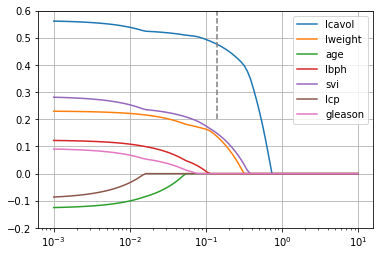

In [109]:
alphas1, coeffs, _ = sklearn.linear_model.lasso_path(x,y,alphas = alphas)
plt.semilogx(alphas1,coeffs.T)
plt.grid()
plt.legend(names_x, loc = "upper right")

plt.semilogx([alpha_opt,alpha_opt],[0.2,0.6],'--')
plt.ylim([-0.2,0.6])


In [111]:
from sklearn.feature_selection import f_regression, mutual_info_regression